## Minimal example

Adversarial attacks on MNIST with torch

In [24]:
import torch
import torchvision
import copy

In [2]:
num_train_epochs = 5

### Prepare data

In [3]:
train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
val_transform = test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1325,), (0.3105,)),
            ]
        )

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=val_transform)

In [5]:
train_dataloader = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=24,
            shuffle=True,
            drop_last=True,
            num_workers=2,
        )
val_dataloader = torch.utils.data.DataLoader(
            dataset=val_dataset,
            batch_size=24,
            shuffle=False,
            drop_last=False,
            num_workers=0,
        )

### Model 

In [6]:
class PytorchExampleNet(torch.nn.Module):
    def __init__(self):
        super(PytorchExampleNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.nn.functional.log_softmax(x, dim=1)
        return output

In [7]:
model = PytorchExampleNet()
if not torch.cuda.is_available():
    raise Exception("cuda is required")
model.cuda()

PytorchExampleNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Train

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
model.train()
for epoch in range(num_train_epochs):
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    epoch_loss = train_loss
    epoch_accuracy = 100.*correct/total
    print("train", epoch, epoch_accuracy, epoch_loss)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

    epoch_loss = test_loss
    epoch_accuracy = 100.*correct/total
    print("val", epoch, epoch_accuracy, epoch_loss)

    

train 0 tensor(21.9083) 5516.46257174015
val 0 tensor(49.3900) 850.8003145456314
train 1 tensor(66.5400) 4246.705506682396
val 1 tensor(78.4900) 514.1091899871826
train 2 tensor(81.2867) 2210.3008322119713
val 2 tensor(85.1700) 260.9531975835562
train 3 tensor(85.9783) 1372.1215751171112
val 3 tensor(87.9100) 192.12499111890793
train 4 tensor(87.9583) 1107.120007827878
val 4 tensor(89.2800) 164.60313782840967


### manual check 

In [10]:
model.eval()
for i in range(3):
    print("label", val_dataset[i][1])
    print("pred", model(val_dataset[i][0][None, :, :].cuda()).argmax().item())
    

label 7
pred 7
label 2
pred 2
label 1
pred 1


### adversarial backprop

change first image in dataset from 7 to 2

In [241]:
# original preds
orig_image = copy.deepcopy(val_dataset[0][0].cuda())
pred = torch.softmax(model(orig_image[None, :, :]), 1)
print("pred", "["+" ".join(["{0:0.3f}".format(i) for i in pred.tolist()[0]])+"]", pred.argmax().item())

pred [0.001 0.000 0.000 0.001 0.000 0.000 0.000 0.991 0.001 0.006] 7


In [242]:
adv_image = torch.Tensor(orig_image)
adv_image.requires_grad = True

In [243]:
optimizer_adv = torch.optim.Adam([adv_image], lr=1e-2, weight_decay=1e-3)
for i in range(100):
    outputs = model(adv_image[None, :, :])
    targets = torch.tensor([2]).cuda()
    optimizer_adv.zero_grad()
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer_adv.step()

In [244]:
print(adv_image.grad.max())

tensor(0.0198, device='cuda:0')


In [245]:
pred_adv = torch.softmax(model(adv_image[None, :, :]), 1)
print("pred", "["+" ".join(["{0:0.3f}".format(i) for i in pred_adv.tolist()[0]])+"]", pred_adv.argmax().item())

pred [0.026 0.001 0.760 0.087 0.003 0.022 0.004 0.073 0.019 0.007] 2


In [246]:
import matplotlib.pyplot

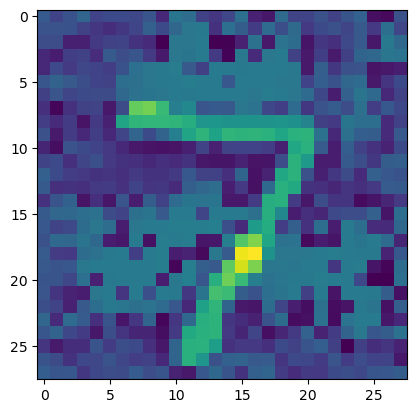

In [247]:
matplotlib.pyplot.imshow(adv_image[0].cpu().detach().numpy())

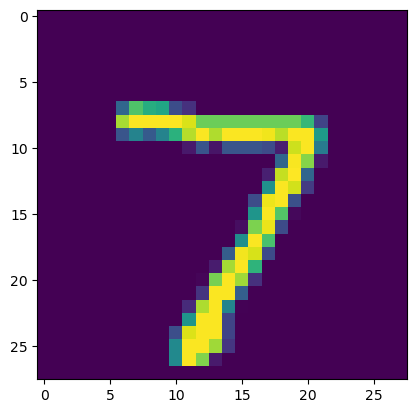

In [248]:
matplotlib.pyplot.imshow(val_dataset[0][0].cpu().numpy()[0])

In [215]:
(val_dataset[0][0][0].cpu()-adv_image[0].cpu()).max()

tensor(0.5708, grad_fn=<MaxBackward1>)

In [182]:
adv_image[0].cpu().max()

tensor(3.6941, grad_fn=<MaxBackward1>)